In [1]:
import os
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Convolution2D
from keras import optimizers
from keras import metrics
from keras.callbacks import EarlyStopping, History, ModelCheckpoint
from keras.layers.core import Flatten, Dense, Dropout, Reshape, Lambda
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import keras.backend as K
from IPython.display import Image
from IPython.display import display
from keras.utils import plot_model
from keras.regularizers import l2
from keras.constraints import maxnorm
from keras.applications.inception_v3 import InceptionV3, preprocess_input

Using TensorFlow backend.


#### Helper functions

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
def get_num_files(path):
    """
    count number of files in this directory and all subfolders
    :param path:
    :return: integer total number of files in path
    """
    if not os.path.exists(path):
        return 0
    return sum([len(files) for r, d, files in os.walk(path)])

In [4]:
def get_num_subfolders(path):
    """
    get number of subfolders inside this path
    :param path:
    :return: integer number of subfolders inside this path
    """
    if not os.path.exists(path):
        return 0
    return sum([len(d) for r, d, files in os.walk(path)])

In [5]:
def create_img_generator():
    """
    define image generator that will be variations
    :return:
    """
    return ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rescale=1./255,
        validation_split=0.2
    )


In [6]:
def get_sample_spectrogram():
    """
    :return: list of spectrogram png files to display them
    """
    Images = [
        'data/train/normal/cl-normal-e00081.wav.jpg',
        'data/train/abnormal/cl-abnormal-a0223.wav.jpg'
    ]

    for imageName in Images:
        display(Image(filename=imageName))

In [7]:
def results(history):
    """

    :param history:
    :return: figure for accuracy and loss
    """
    # Accuracy
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()



In [8]:
# Main code
Image_width, Image_height = 150, 150
Training_Epochs = 100
Batch_Size = 64
Number_FC_Neurons = 1024
nb_filter=90
nb_classes=2
hidden_dims=256
train_dir = 'data/train'

In [9]:
train_image_gen = create_img_generator()
test_image_gen  = create_img_generator() 

In [10]:
train_generator = train_image_gen.flow_from_directory(
    train_dir,
    target_size=(Image_width, Image_height),
    batch_size=Batch_Size,
    seed=42,
    subset='training',
    save_to_dir='data/aug_training'
)

Found 2592 images belonging to 2 classes.


In [11]:
validation_generator = test_image_gen.flow_from_directory(
    train_dir,
    target_size=(Image_width, Image_height),
    batch_size=Batch_Size,
    seed=42,
    subset='validation'
)

Found 648 images belonging to 2 classes.


In [98]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),
                 activation="relu",
                 input_shape=(Image_width,Image_height,3))
         )

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), activation='elu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())


model.add(Conv2D(64, (3,3), activation='elu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3,3), activation='elu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())



model.add(Conv2D(256, (3,3), activation='elu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Flatten())

model.add(Dense(128, activation='elu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Each time the loss will drop it will save weights file
weights = 'cnn-weights.json'
checkpointer = ModelCheckpoint(filepath=weights, verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_acc', patience=5, mode='auto')
my_callbacks = [checkpointer,early_stopping]
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 74, 74, 32)        128       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 36, 36, 64)        256       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 34, 34, 64)        36928     
__________

In [99]:
hist = model.fit_generator(
    train_generator,
    epochs=Training_Epochs,
    verbose=1,
    steps_per_epoch=2592 // Batch_Size,
    validation_data=validation_generator,
    validation_steps= 648 // Batch_Size,
    class_weight='auto',
    shuffle=True,
    callbacks=my_callbacks,

)

Epoch 1/100
40/40 [==============================] - 89s 2s/step - loss: 1.0440 - acc: 0.7047 - val_loss: 0.8269 - val_acc: 0.7953

Epoch 00001: val_loss improved from inf to 0.82694, saving model to cnn-weights.json
Epoch 2/100
40/40 [==============================] - 88s 2s/step - loss: 0.8580 - acc: 0.7293 - val_loss: 0.6722 - val_acc: 0.7877

Epoch 00002: val_loss improved from 0.82694 to 0.67215, saving model to cnn-weights.json
Epoch 3/100
40/40 [==============================] - 89s 2s/step - loss: 0.7803 - acc: 0.7157 - val_loss: 0.7414 - val_acc: 0.7979

Epoch 00003: val_loss did not improve from 0.67215
Epoch 4/100
40/40 [==============================] - 92s 2s/step - loss: 0.6900 - acc: 0.7438 - val_loss: 0.6608 - val_acc: 0.7997

Epoch 00004: val_loss improved from 0.67215 to 0.66084, saving model to cnn-weights.json
Epoch 5/100
40/40 [==============================] - 95s 2s/step - loss: 0.6378 - acc: 0.7402 - val_loss: 0.6044 - val_acc: 0.7911

Epoch 00005: val_loss impr

In [100]:
model.evaluate_generator(validation_generator, 648)

[0.7480889102525918, 0.7885883214734198]

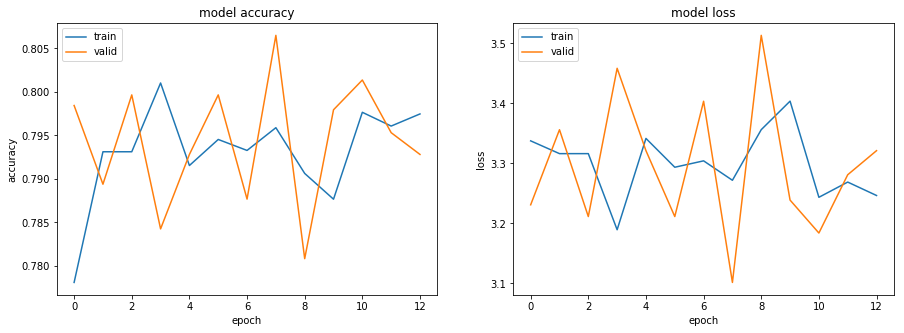

In [95]:
results(hist)

### Another CNN

In [13]:
model = Sequential()
# We start off with using Convolution2D for a frame
    # The filter is 3x57
model.add(Convolution2D(nb_filter=nb_filter,
                            nb_row=3,
                            nb_col=57,
                            init='orthogonal',
                            border_mode='valid',
                            W_regularizer=l2(0.0001),
                            W_constraint = maxnorm(2),
                            input_shape=(Image_width, Image_height, 3)))
model.add(Activation('relu'))
    
    # dropout to reduce overfitting:
model.add(Dropout(0.25))
    
    # we use standard max pooling (halving the output of the previous layer):
model.add(MaxPooling2D(pool_size=(3, 4), strides=(1, 3)))
    
    # the second convolution layer is 1x3
model.add(Convolution2D(nb_filter, 
                            nb_row=1,
                            nb_col=3,
                            init='orthogonal', 
                            W_regularizer=l2(0.0001), 
                            W_constraint=maxnorm(2)))

model.add(Activation('relu'))
model.add(Dropout(0.25))
    
    # we use max pooling again:
model.add(MaxPooling2D(pool_size=(1, 3), strides=(1, 3)))
    
    # We flatten the output of the conv layer,
    # so that we can add a vanilla dense layer:
model.add(Flatten())

    # we add two hidden layers:
    # increasing number of hidden layers may increase the accuracy, current number is designed for the competition 
model.add(Dense(hidden_dims, 
                    init='orthogonal', 
                    W_regularizer=l2(0.0001), 
                    W_constraint = maxnorm(2)))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(hidden_dims, 
                    init='orthogonal', 
                    W_regularizer=l2(0.0001), 
                    W_constraint = maxnorm(2)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
    
# We project onto a binary output layer to determine the category (Currently: normal/abnormal, but you can try train on the exact abnormality also)
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(input_shape=(150, 150,..., kernel_size=(3, 57), filters=90, padding="valid", kernel_initializer="orthogonal", kernel_regularizer=<keras.reg..., kernel_constraint=<keras.con...)`
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(90, (1, 3), kernel_initializer="orthogonal", kernel_regularizer=<keras.reg..., kernel_constraint=<keras.con...)`
/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, kernel_initializer="orthogonal", kernel_regularizer=<keras.reg..., kernel_constraint=<keras.con...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 94, 90)       46260     
_________________________________________________________________
activation_1 (Activation)    (None, 148, 94, 90)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 148, 94, 90)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 146, 31, 90)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 29, 90)       24390     
_________________________________________________________________
activation_2 (Activation)    (None, 146, 29, 90)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 146, 29, 90)       0         
__________

/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, kernel_initializer="orthogonal", kernel_regularizer=<keras.reg..., kernel_constraint=<keras.con...)`


In [14]:
weights = 'another-cnn-weights.json'
checkpointer = ModelCheckpoint(filepath=weights, verbose=1, save_best_only=True)

In [ ]:
hist = model.fit_generator(
    train_generator,
    epochs=Training_Epochs,
    verbose=1,
    steps_per_epoch=2592 // Batch_Size,
    validation_data=validation_generator,
    validation_steps= 648 // Batch_Size,
    class_weight='auto',
    shuffle=True,
    callbacks=[checkpointer],
)

Epoch 1/100
40/40 [==============================] - 232s 6s/step - loss: 3.5313 - acc: 0.7844 - val_loss: 3.2853 - val_acc: 0.8000

Epoch 00001: val_loss improved from inf to 3.28534, saving model to another-cnn-weights.json
Epoch 2/100
40/40 [==============================] - 217s 5s/step - loss: 3.4394 - acc: 0.7902 - val_loss: 3.2589 - val_acc: 0.8014

Epoch 00002: val_loss improved from 3.28534 to 3.25894, saving model to another-cnn-weights.json
Epoch 3/100
40/40 [==============================] - 219s 5s/step - loss: 3.3048 - acc: 0.7984 - val_loss: 3.3937 - val_acc: 0.7928

Epoch 00003: val_loss did not improve from 3.25894
Epoch 4/100
40/40 [==============================] - 215s 5s/step - loss: 3.3964 - acc: 0.7926 - val_loss: 3.4197 - val_acc: 0.7911

Epoch 00004: val_loss did not improve from 3.25894
Epoch 5/100
40/40 [==============================] - 214s 5s/step - loss: 3.3450 - acc: 0.7957 - val_loss: 3.0893 - val_acc: 0.8116

Epoch 00005: val_loss improved from 3.25894

40/40 [==============================] - 210s 5s/step - loss: 3.2499 - acc: 0.8004 - val_loss: 3.4261 - val_acc: 0.7894

Epoch 00044: val_loss did not improve from 2.80515
Epoch 45/100
40/40 [==============================] - 224s 6s/step - loss: 3.3558 - acc: 0.7938 - val_loss: 3.3306 - val_acc: 0.7953

Epoch 00045: val_loss did not improve from 2.80515
Epoch 46/100
40/40 [==============================] - 217s 5s/step - loss: 3.4245 - acc: 0.7894 - val_loss: 3.4802 - val_acc: 0.7860

Epoch 00046: val_loss did not improve from 2.80515
Epoch 47/100
40/40 [==============================] - 226s 6s/step - loss: 3.3112 - acc: 0.7965 - val_loss: 3.1778 - val_acc: 0.8048

Epoch 00047: val_loss did not improve from 2.80515
Epoch 48/100
40/40 [==============================] - 233s 6s/step - loss: 3.3673 - acc: 0.7930 - val_loss: 3.3970 - val_acc: 0.7911

Epoch 00048: val_loss did not improve from 2.80515
Epoch 49/100
40/40 [==============================] - 224s 6s/step - loss: 3.2786 - acc:

In [45]:
model.evaluate_generator(validation_generator)

[3.2909253320576233, 0.7947530864197531]

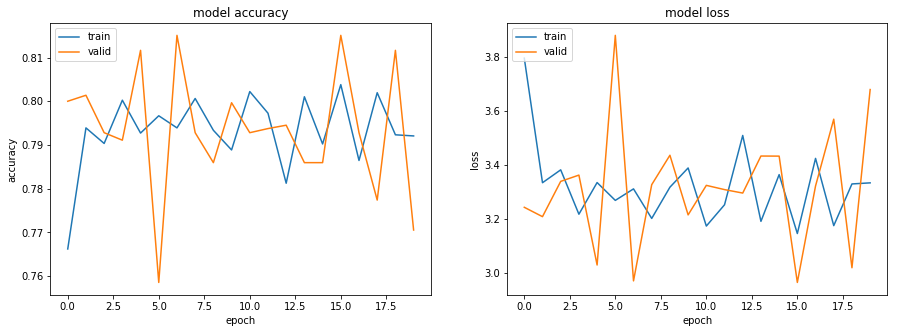

In [46]:
results(hist)

### Transfer learning

In [13]:
# Load the inception v3 model and load it with it's pre-trained weights. but exclude
# the final fully connected layer
InceptionV3_base_model = InceptionV3(weights='imagenet', include_top=False)
print('Inception V3 base model')

Inception V3 base model


In [14]:
# define the layers in the new classification prediction
x = InceptionV3_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(Number_FC_Neurons, activation='relu')(x) # new fc layer , random init
predictions = Dense(nb_classes, activation='softmax')(x) # new softmax layer

NameError: name 'GlobalAveragePooling2D' is not defined